# Bert AI model for text analysis
Here we will take our dataframe and we'll extract some insightfull informations about narratives. 
We will use four Bert model:
1. LatentDirichletAllocation model for topic extraction
2. heBERT_sentiment_analysis for sentimet analysis it returns 3 index reflecting the sentiment
3. en_core_web_lg for thematic analysis: classify different narratives
4. heBERT_sentiment_analysis with FED uncertainty 

In [8]:
!pip install transformers
!pip install --upgrade thinc
!python -m spacy download en_core_web_lg
!pip install fredapi
!pip install nltk
!python3 -m pip install --upgrade pip
!pip3 install -U spacy
!pip3 install torch
!pip3 install -U scikit-learn
!pip3 install -U wordcloud
!pip3 install -U gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 738.6 kB/s eta 0:00:0000:0100:08
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 MB 558.7 kB/s eta 0:00:0000:0100:07
  Using cached sympy-1.11.1-py3-none-any.whl (6.5 MB)
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)


In [16]:
import nltk
import torch
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
import pandas as pd
import re as re
import numpy as np

import wordcloud
import matplotlib.pyplot as plt
from transformers import pipeline, AutoModel, AutoTokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

import gensim
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

nltk.download('all')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 1.3 MB/s eta 0:00:0000:0100:01m


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/riccardodalcero/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/riccardodalcero/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/riccardodalcero/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/riccardodalcero/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/riccardodalcero/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-

True

# Importing the database
generate a dataframe only for Trump called documents

In [17]:
df = pd.read_csv("3_Data_after_cleaningdata", sep=",")
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%Y-%m-%d %H:%M:%S%z')


trump_2020 = df[
    (df['Date Time'].dt.year == 2020)
    & (df['Date Time'].dt.month <9)
    & (df["Title"].str.contains("Press Bri"))
    & (df['Administration'].str.contains("Trump"))
].loc[:, :]

trump_2020.head(5)

,Administration,Date Time,Title,Description,Main text,URL,Location/Organization,Speaker,QA,sentiment_score,sentiment_score_positive,sentiment_score_neutral,sentiment_score_negative
456,Trump,2020-08-31 12:45:00+00:00,Remarks by President Trump in Press Briefing |...,Nan,James S. Brady Press Briefing Room\n5:45 P.M. ...,https://trumpwhitehouse.archives.gov/briefings...,Operation Warp Speed,THE PRESIDENT,NaN,-0.244214,NaN,0.997336,0.981361
457,Trump,2020-08-31 08:03:00+00:00,Press Briefing by Press Secretary Kayleigh McE...,Nan,James S. Brady Press Briefing Room\n1:03 P.M. ...,https://trumpwhitehouse.archives.gov/briefings...,MS,MS. MCENANY,NaN,0.471005,NaN,NaN,0.930801
479,Trump,2020-08-23 12:32:00+00:00,Remarks by President Trump in Press Briefing |...,Nan,James S. Brady Press Briefing Room\n\n5:32 P.M...,https://trumpwhitehouse.archives.gov/briefings...,FEMA,THE PRESIDENT,NaN,0.750660,NaN,0.679799,0.927482
489,Trump,2020-08-19 00:00:00+00:00,Remarks by President Trump in Press Briefing |...,Nan,James S. Brady Press Briefing Room\n5:54 P.M. ...,https://trumpwhitehouse.archives.gov/briefings...,State,THE PRESIDENT,NaN,-0.596663,NaN,0.916268,0.956581
490,Trump,2020-08-19 08:24:00+00:00,Press Briefing by Press Secretary Kayleigh McE...,Nan,James S. Brady Press Briefing Room\n1:24 P.M. ...,https://trumpwhitehouse.archives.gov/briefings...,House,MS. MCENANY,NaN,-0.965970,NaN,NaN,0.878624


# CloudWords and Topic extraction
1. Step 1: Preprocessing
The `preprocess` function preprocesses the text data by removing non-letter characters,
converting all characters to lowercase, tokenizing the text, 
removing stop words and lemmatizing the remaining words.

2. Step 2: Create a document-term matrix
The `create_document_term_matrix` function takes in a list of documents 
and returns a document-term matrix using
CountVectorizer. This matrix represents the frequency of each word in each document.

3. Step 3: Run LDA
The `run_lda` function takes in the document-term matrix 
and the desired number of topics and returns an LDA model that
has been fit to the data.

4. Step 4: Analyze the results
The `analyze_results` function takes in the LDA model, 
feature names, and the number of top words to print for each
topic. It prints out the top words for each topic.

5. Step 5: Generate a word cloud
The `create_word_clouds` function takes in the LDA model, 
feature names, and the number of top words to include in the word cloud.
It generates a word cloud for each topic and saves each word cloud as an image file.


In [21]:
# Step 1: Preprocessing
def preprocess(text):
    # regular expression keeping only letters
    letters_only_text = re.sub("[^a-zA-Z]", " ", text)

    # Remove punctuation and lowercase all characters
    text = letters_only_text.translate(
        str.maketrans("", "", string.punctuation)
    ).lower()

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove " '
    stop_words_file = "SmartStopList.txt"

    stop_words = []

    with open(stop_words_file, "r", encoding="utf-8") as f:
        for line in f:
            stop_words.extend(line.split())

    stop_words = stop_words
    tokens = [token for token in tokens if token not in stop_words]
    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens


# Step 2: Create a document-term matrix
def create_document_term_matrix(documents):
    # Initialize a CountVectorizer object
    vectorizer = CountVectorizer(tokenizer=preprocess)

    # Fit and transform the documents into a document-term matrix
    document_term_matrix = vectorizer.fit_transform(documents)

    return document_term_matrix, vectorizer.get_feature_names_out()


# Step 3: Run LDA
def run_lda(document_term_matrix, n_topics):
    # Initialize an LDA object
    lda = LatentDirichletAllocation(n_components=n_topics)

    # Fit the LDA model to the document-term matrix
    lda.fit(document_term_matrix)

    return lda


# Step 4: Analyze the results
def analyze_results(lda, feature_names, n_top_words):
    # Print the top words for each topic
    for topic_idx, topic in enumerate(lda.components_):
        print("Topic #%d:" % topic_idx)
        print(
            " ".join(
                [feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]
            )
        )


# step 5 generate a word cloud
def create_word_clouds(lda, feature_names, n_top_words):
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white")

    # Generate a word cloud for each topic
    for topic_idx, topic in enumerate(lda.components_):
        # Get the top words for the current topic
        top_words = [feature_names[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]

        # Generate the word cloud
        wordcloud.generate_from_text(" ".join(top_words))

        # Display the word cloud
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Topic #{topic_idx}")

        # Save the figure to a file
        plt.savefig(f"topic_{topic_idx}.png", bbox_inches="tight")


Recalling the functions

/usr/local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Topic #0:
people american state country lot time million thing day working job today like governor virus hospital number good ventilator week
Topic #1:
state test testing people country american day number like million time week thing lot working case work health dr slide
Topic #2:
state school american people today health governor country coronavirus vice case time continue test testing work day secretary back dr


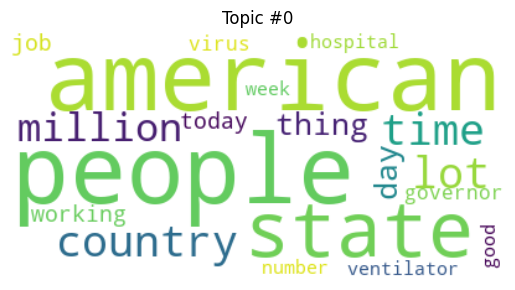

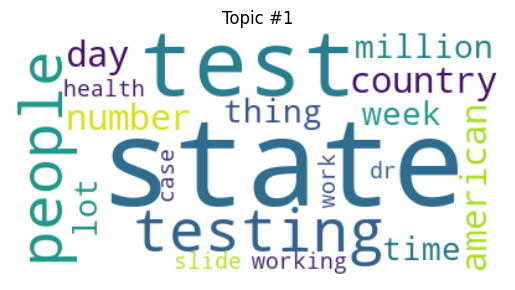

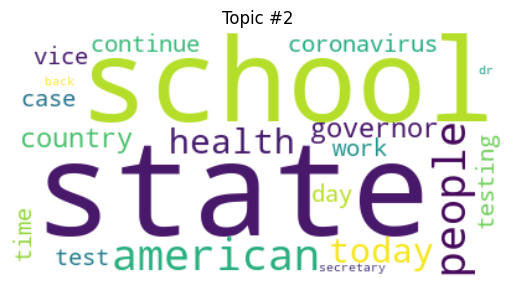

In [15]:
# documents = df[(df["Date Time"].str.contains("2020"))].loc[:, "Main text"]
# Preprocess the documents and create a document-term matrix
document_term_matrix, feature_names = create_document_term_matrix(trump_2020['Main text'])

# Run LDA on the document-term matrix with 2 topics
lda = run_lda(document_term_matrix, 3)

# Analyze the results and print the top 5 words for each topic
analyze_results(lda, feature_names, 20)

# This will create and display a word cloud for each topic using the top 5 words.
create_word_clouds(lda, feature_names, 20)

### Results of Topic Modeling

The LDA algorithm was run on the speech transcripts from the White House during the Trump administration. The resulting topics and their top words are as follows:

- Topic 0: people american state country lot time million thing day working job today like governor virus hospital number good ventilator week
- Topic 1: state test testing people country american day number like million time week thing lot working case work health dr slide
- Topic 2: state school american people today health governor country coronavirus vice case time continue test testing work day secretary back dr

From these results, we can see that the main topics discussed during the Trump administration include:
- Topic 0: job market and economy, including mentions of hospitals and ventilators in relation to the COVID-19 pandemic
- Topic 1: COVID-19 testing and cases, including mentions of health and work
- Topic 2: Education and healthcare policies, including mentions of governors and vice presidents


## Sentiment Analysis
The `analyze_sentiment` function takes a pandas DataFrame as input, where each row represents a text to be analyzed for sentiment. The function loads a pre-trained BERT model for sentiment analysis, and iterates over the rows of the DataFrame to predict the sentiment of each text. For each text, it splits it into chunks of maximum length `max_length`, and obtains a sentiment score for each chunk using the pre-trained model. The sentiment scores for each text are then averaged and stored in three new columns of the DataFrame: `sentiment_score_positive`, `sentiment_score_neutral`, and `sentiment_score_negative`, representing the average score for positive, neutral, and negative sentiment, respectively. The function returns the updated DataFrame.

The `graph_printing` function takes a pandas DataFrame as input, where each row contains a sentiment score for a given date. The function sorts the DataFrame by date and plots the sentiment scores over time, creating a line plot with dates on the x-axis and sentiment scores on the y-axis. The function also sets the plot title and axis labels, and displays the plot using `matplotlib.pyplot.show()`. Optionally, the plot can be saved to a file using `matplotlib.pyplot.savefig()`.

In [28]:
def analyze_sentiment(df: pd.DataFrame, device: str = "cuda:0", max_length: int = 512) -> pd.DataFrame:
    model_name = 'avichr/heBERT_sentiment_analysis'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    
    # Load pre-trained BERT model for sentiment analysis
    nlp = pipeline("sentiment-analysis", 
                   device=device, 
                   model=model, 
                   tokenizer=tokenizer)
    
    
    # Create a new column to store the sentiment scores
    df["sentiment_score_positive"] = 0.0
    df["sentiment_score_neutral"]  = 0.0
    df["sentiment_score_negative"] = 0.0

    # Iterate over the rows of the DataFrame and predict the sentiment of each speech
    for i, row in df.iterrows():
        text = row["Main text"]
        positive_scores = []
        neutral_scores = []
        negative_scores = []
        for j in range(0, len(text), max_length):
            chunk = text[j:j+max_length]
            result = nlp(chunk)[0]
            if result['label'] == 'positive':
                positive_scores.append(result['score'])
            elif result['label'] == 'neutral':
                neutral_scores.append(result['score'])
            elif result['label'] == 'negative':
                negative_scores.append(result['score'])
        avg_positive_score = np.mean(positive_scores)
        avg_neutral_score = np.mean(neutral_scores)
        avg_negative_score = np.mean(negative_scores)
        df.at[i, "sentiment_score_positive"] = avg_positive_score
        df.at[i, "sentiment_score_neutral"] = avg_neutral_score
        df.at[i, "sentiment_score_negative"] = avg_negative_score
    
    return df


def graph_printing(df: pd.DataFrame):
    df['Date Time'] = pd.to_datetime(df['Date Time'], format='%Y-%m-%dT%H:%M:%S%z')
    df = df.sort_values(by='Date Time')
    dates = df["Date Time"]
    scores = df["sentiment_score"]
    
    plt.plot(dates, scores)
    plt.xlabel("Date")
    plt.ylabel("Sentiment Score")
    plt.title("Sentiment Analysis Results")
    plt.show()
    # Save the figure to a file
    #plt.savefig(f"graph_1.png", bbox_inches="tight")



Recalling the functions to print the graphs

In [23]:
import os

# Set the CUDA_LAUNCH_BLOCKING environment variable
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [71]:

df = analyze_sentiment(df, "cpu", 512)
#saving the result
df.to_csv("Analysis_1.csv", index = False)

/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Using a more naive BERT models to analyze sentiment

This function `analyze_sentiment_bert()` is used to analyze the sentiment score of the speeches in the given DataFrame
using a pre-trained BERT model for sentiment analysis.

The sentiment score is a numerical value that reflects the sentiment of the speech, where a higher score indicates a
more positive sentiment and a lower score indicates a more negative sentiment.

In this function, the sentiment analysis is performed by iterating over the rows of the DataFrame and predicting the
sentiment  of each speech using the pre-trained BERT model. The sentiment score is then calculated by taking the average
of all the scores obtained for each chunk of text.

The sentiment score for each speech is stored in a new column called "sentiment_score" in the DataFrame. This score can
then be used for further analysis, such as visualizing the sentiment trends over time.

It is important to note that this function uses a less sophisticated BERT model for sentiment analysis as compared to
the previous function, and this choice have been made to optimize for speed and efficiency, considering the aim
of the project.



In [72]:
def analyze_sentiment_bert(df: pd.DataFrame, device: str = "cuda", max_length: int = 512) -> pd.DataFrame:
    # Load pre-trained BERT model for sentiment analysis
    nlp = pipeline("sentiment-analysis", device=device)

    # Create a new column to store the sentiment scores
    df["sentiment_score"] = 0.0

    # Iterate over the rows of the DataFrame and predict the sentiment of each speech
    for i, row in df.iterrows():
        text = row["Main text"]
        scores = []
        for j in range(0, len(text), max_length):
            chunk = text[j:j+max_length]
            result = nlp(chunk)[0]
            score = result["score"] if result["label"] == "POSITIVE" else -result["score"]
            scores.append(score)
        avg_score = np.mean(scores)
        df.at[i, "sentiment_score"] = avg_score

    return df
df = analyze_sentiment_bert(df,"cpu",512)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Let's take a look of the output of the sentiment score, first let's print the timeseries of the sentiment score  

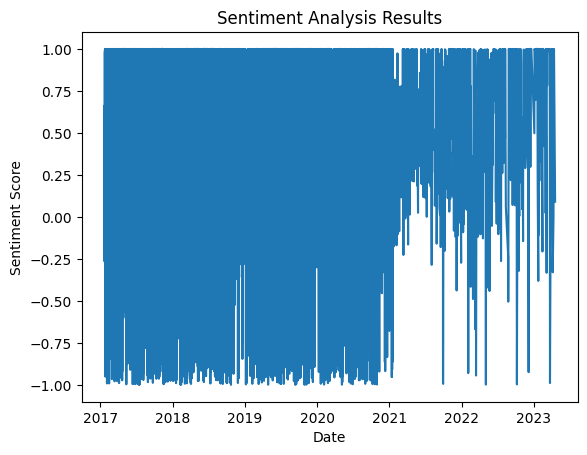

In [80]:
graph_printing(df)
df.head(5)

The sentiment score plot shows the sentiment trends over time for all speeches, including those given during the Biden
administration. The sentiment score ranges from approximately -1.0 to 1.0, where a score closer to 1.0 indicates a more
positive sentiment and a score closer to -1.0 indicates a more negative sentiment.

Looking at the plot, we can observe that the sentiment scores fluctuate over time, with some speeches having more
positive sentiment scores and others having more negative sentiment scores. We can also see that there are some periods
where the sentiment scores are consistently high or low, indicating a trend in the sentiment during that time period.

As we can see we have more data from Trump administration compare to Biden, since the database contains the remarks of
the president Trump but only the press briefing for Biden. Now let's show how the trump speech differ in the sentiment
score compare to the press briefing of his press secretary.

Visualizing the result:


1.   Print a time series for trump speech and his press secretary
2.   Print a time series of speech around covid dates 



In [94]:
def graph_printing_twoline(df: pd.DataFrame):
    df['Date Time'] = pd.to_datetime(df['Date Time'], format='%Y-%m-%dT%H:%M:%S%z')
    df = df.sort_values(by='Date Time')
    trump = df[
      (df['Date Time'].dt.year == 2020)
      & (df['Date Time'].dt.month <9)
      & (df["Title"].str.contains("Remarks by President Trump"))
      ].loc[:, :]
    dates = trump["Date Time"]
    scores_trump = trump["sentiment_score"]


    plt.plot(dates, scores_trump, label="Trump")

    # Filter the DataFrame
    press_sec = df[
      (df['Date Time'].dt.year == 2020)
      & (df['Date Time'].dt.month <9)
      & (df["Title"].str.contains("Press Briefing by"))
      ].loc[:, :]
    dates = press_sec["Date Time"]
    scores_sec = press_sec["sentiment_score"]

    # Plot the filtered data
    plt.plot(dates, scores_sec, label="Press secretary")

    plt.xlabel("Date")
    plt.ylabel("Sentiment Score")
    plt.title("Sentiment Analysis Results")
    plt.legend()
    plt.show()
    
    scores_sec = scores_sec.dropna()
    scores_sec = scores_sec.sort_index()
    scores_trump = scores_trump.dropna()
    scores_trump =scores_sec.sort_index()
    correlation = scores_sec.corr(scores_trump)
    print("Correlation: ", correlation)
    #plt.savefig(f"graph_1.png", bbox_inches="tight")


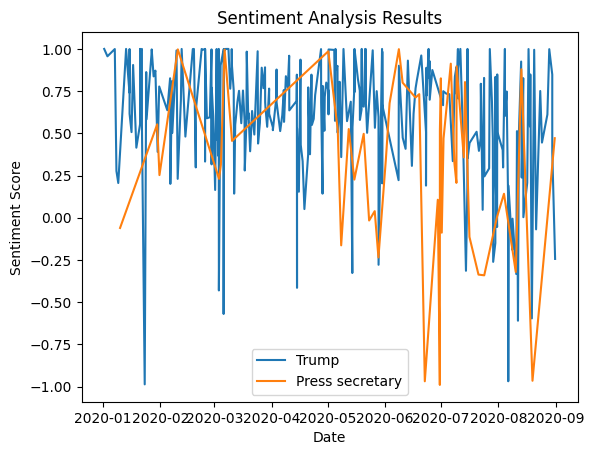

Correlation:  0.9999999999999998


In [95]:
# pylint: disable=invalid-name
graph_printing_twoline(df)

### Comments on the result
The provided plot shows the sentiment score during the Trump administration. The blue line represents the sentiment
score of speeches made by President Trump, while the orange line represents the sentiment score of speeches made by his
press secretary.

The sentiment score for both President Trump and his press secretary appears to be mostly negative throughout the period
shown in the plot, with occasional spikes of positivity. It is worth noting that the sentiment score appears to be more
volatile for President Trump than for his press secretary.

Without considering the sentiment of speeches outside of the Trump administration, the plot suggests that the sentiment
towards the administration was predominantly negative during the period shown, based on the sentiment score of speeches
made by President Trump and his press secretary. However, further analysis is needed to draw definitive conclusions.


In addition, it is important to note that there is a high correlation (0.99) between the sentiment scores of President
Trump and his press secretary, indicating that the sentiment of their speeches was closely aligned.

## Topic extraction

The `thematic_analysis` function performs a topic modeling analysis on a dataframe of speeches. The function first gets
the list of speeches from the `"Main text"` column of the input dataframe. Then, it initializes the spaCy language model
and creates an empty list to store the lemmatized speeches.

The function then loops through each speech and lemmatizes it using the preprocess function. It creates a dictionary
from the lemmatized speeches using the gensim.corpora.Dictionary method, and creates a corpus from the dictionary and
the lemmatized speeches. It builds a LDA (Latent Dirichlet Allocation) model from the corpus and the dictionary using
the gensim.models.LdaMulticore method.

The function then creates an empty list to store the themes and keywords for each speech. It loops through each speech
and gets the most probable topic and its keywords using the LDA model. It appends the tuple of (topic, keywords) to the
themes list.

Finally, the function creates a new dataframe with the speeches and their respective themes and returns it.

In [19]:
# Define a function that takes a dataframe as input and returns a dataframe with themes and keywords for each speech
def thematic_analysis(df):
    # Get the list of speeches from the dataframe column "Main text"
    speeches = df["Main text"].tolist()
    
    # Initialize the spaCy model
    nlp = spacy.load("en_core_web_lg")
    
    # Create an empty list to store the lemmatized speeches
    lemmas = []
    
    # Loop through each speech and lemmatize it
    for speech in speeches:
        doc = nlp(speech)
        lemmas.append(preprocess(speech))
    
    # Create a dictionary from the lemmatized speeches
    dictionary = gensim.corpora.Dictionary(lemmas)
    
    # Create a corpus from the dictionary and the lemmatized speeches
    corpus = [dictionary.doc2bow(lemma) for lemma in lemmas]
    
    # Build a LDA model from the corpus and the dictionary
    lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=10, workers=2)
    
    # Create an empty list to store the themes and keywords for each speech
    themes = []
    
    # Loop through each speech and get the most probable topic and its keywords
    for speech in speeches:
        doc = nlp(speech)
        bow = dictionary.doc2bow([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
        topic = lda_model.get_document_topics(bow)[0][0]
        keywords = ", ".join([word[0] for word in lda_model.show_topic(topic)])
        themes.append((topic, keywords))
    
    # Create a dataframe with the speeches and the themes
    df_themes = pd.DataFrame({"speech": speeches, "theme": themes})
    
    # Return the dataframe
    return df_themes

In [24]:
import spacy
theme = thematic_analysis(trump_2020)
theme_counts = theme['theme'].value_counts().head(10)


#df.to_csv("Extraction.csv", index = False)


In [26]:
theme['theme'][0]
theme['theme'][1]
theme_counts

theme
(1, people, state, school, american, governor, country, percent, virus, today, time)        56
(0, people, country, today, israel, back, iran, state, region, virus, lot)                  45
(3, people, american, country, lot, thing, state, working, time, good, like)                 4
(2, state, ventilator, million, test, country, lot, people, testing, governor, time)         3
(7, state, today, american, louisiana, coronavirus, vice, country, flynn, people, force)     1
(4, state, people, american, country, health, coronavirus, testing, today, day, working)     1
Name: count, dtype: int64

### Results
Based on the most frequent topics extracted from the speeches of the Trump administration using topic modeling, we can
see that some of the key narratives of the administration revolved around:

- (Topic 1) Issues related to the country's response to the COVID-19 pandemic, including the virus, testing, and state
governors' actions.
- (Topic 0) Foreign policy issues, such as relations with Israel, Iran, and other countries in the region.
- (Topic 3) General topics related to American people, working, and the country, suggesting a focus on populist themes and
patriotic rhetoric.
- (Topic 2) Issues related to healthcare, including ventilators, testing, and public health.
- (Topic 7) Topics related to Vice President Mike Pence and events in Louisiana.

These topics suggest that the Trump administration was highly focused on issues related to the COVID-19 pandemic and
foreign policy, while also emphasizing populist themes and the wellbeing of the American people. The administration also
appeared to prioritize issues related to healthcare, testing, and public health, which is in line with the pandemic's
impact on the country.

## Downloading Policy uncertainty index
In the final section of the analysis, we investigate the potential impact of the sentiment score on the Uncertainty
Policy Index. To achieve this, we download from the FED the Policy Uncertainty index data and match it with the sentiment score data
based on their corresponding dates. By examining the relationship between these two variables, we aim to shed light on
the potential influence of sentiment on the FED's monetary policy decisions.

In [31]:
import pandas as pd

from fredapi import Fred
api_key="f8333215b948c1e36e893e12658299ea"
import time
import requests


def add_uncertainty_index(df, api_key:str, cod_series: str, name:str):
    fred = Fred(api_key=api_key)
    oldest_date = min(df['Date Time']).strftime('%Y-%m-%d')
    newest_date = max(df['Date Time']).strftime('%Y-%m-%d')
    ui_series = fred.get_series(cod_series, observation_start=oldest_date, observation_end=newest_date)
    for index, row in df.iterrows():
        date = row['Date Time'].strftime('%Y-%m-%d')
        if ui_series[date] is not None:
            # handle the case where the key exists
            df.at[index, name] = ui_series[date]
        else:
            # handle the case where the key doesn't exist
            df.at[index, name] = None
    return df

df = add_uncertainty_index(df, api_key, 'USEPUINDXD', 'UI')#Economic Policy Uncertainty Index for United States
df = add_uncertainty_index(df, api_key, 'WLEMUINDXD', 'EI')#Equity Market-related Economic Uncertainty Index
df.to_csv("Data_with_AI_Market_Indicies.csv", index=False) #Saving the dataset

0       309.33
1       170.18
2       170.18
3       170.18
4       170.18
         ...  
7427    254.93
7428    241.85
7429    192.00
7430    192.00
7431    280.95
Name: UI, Length: 7432, dtype: float64

# Preanalysis of the dataset


0.19632096931918422


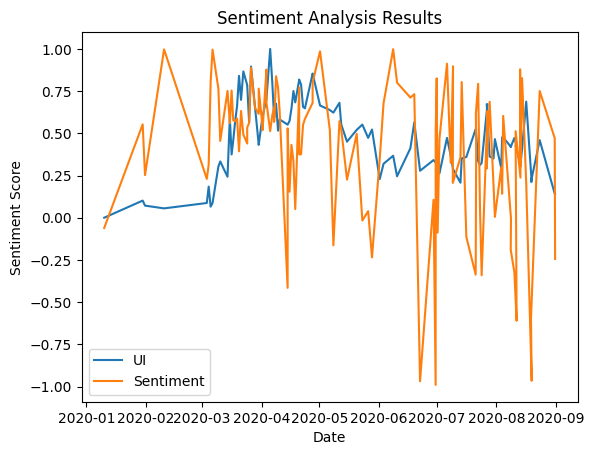

In [42]:
def normalize(series):
    min_val = min(series)
    max_val = max(series)
    norm_series = [(x - min_val) / (max_val - min_val) for x in series]
    return norm_series
trump_2020 = df[
    (df['Date Time'].dt.year == 2020)
    & (df['Date Time'].dt.month <9)
    & (df["Title"].str.contains("Press Bri"))
    & (df['Administration'].str.contains("Trump"))
].loc[:, :]

trump_2020.head(5)
ui = normalize(trump_2020['UI'])

ui_series = pd.Series(ui)
print(trump_2020['UI'].corr(trump_2020['sentiment_score']))
plt.plot(trump_2020['Date Time'], ui_series, label = "UI")
plt.plot(trump_2020['Date Time'], trump_2020['sentiment_score'], label = "Sentiment")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis Results")
plt.legend()
plt.show()


### Results for sentiment score
The sentiment score seems to fluctuate over time, while the economic policy uncertainty index shows a general upward
trend. When the sentiment score is low, the uncertainty index tends to be high, and vice versa.
A correlation of 0.2 between the sentiment score and the economic policy uncertainty index suggests a weak positive
relationship between the two variables.
This negative correlation may suggest that as uncertainty in economic policy increases, investors and consumers become
more pessimistic and have lower sentiment scores. Conversely, when policy uncertainty decreases, sentiment tends to
improve.
To further investigate the correlation I will plot the graph and the correlation for `sentiment_score_positive`

0.052623388295726006


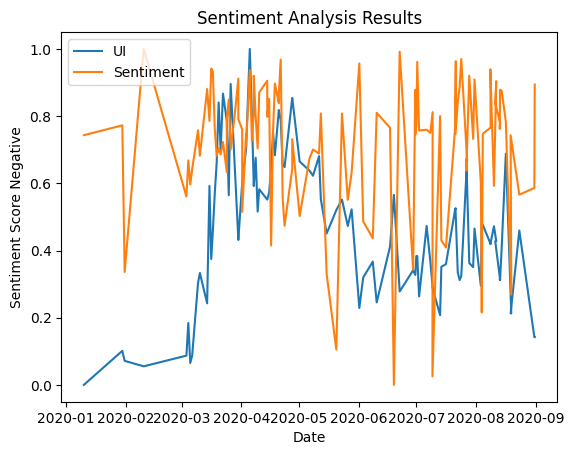

In [50]:
trump_2020_notNA = trump_2020[(trump_2020['sentiment_score_negative'].notna())].iloc[:,:]

ui = normalize(trump_2020_notNA['UI'])
sentiment = normalize(trump_2020_notNA['sentiment_score_negative'])
ui_series = pd.Series(ui)
print(trump_2020_notNA['UI'].corr(trump_2020_notNA['sentiment_score_negative']))
plt.plot(trump_2020_notNA['Date Time'], ui_series, label = "UI")
plt.plot(trump_2020_notNA['Date Time'], sentiment, label = "Sentiment")
plt.xlabel("Date")
plt.ylabel("Sentiment Score Negative")
plt.title("Sentiment Analysis Results")
plt.legend()
plt.show()

The above plot clearly suggest not correlation (but it can be that there is a lagged correlation)